# Tubo Neural

In [1]:
simplificador = False # Se o simplificador = True o projeto irá recuperar checkpoints dos dados processados fazendo com que seja mais rápido rodar o notebook
seed =  42 # Semente
no_anomalies_proportion = 1 #Proporção de não anomalias em relação as anomalias

## Variaveis de Interesse 

In [2]:
target_anomalies = ['Q66','Q69','Q71','Q72','Q73','Q743']
target_years = list(range(2010,2020))
target_states = ['SP','RJ','ES','MG']

## Importing Libs

In [3]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(os.path.join(os.path.abspath(os.getcwd()).replace('= ',''),'..'))
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import PipelineProfiler
import multiprocessing
import autosklearn.classification
from collections import Counter
#from imblearn.under_sampling import ClusterCentroids
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from src.features.feature_selection import Feature_Selection
from src.features.feature_engineering import Feature_Engineering
from src.visualization.visualize import Visualizer
from src.data.retrievers import SINASC_Retriever
from src.data.explorer import GraphExplorer
from src.io_utils import IO_Utils

/l/disk0/msasso/.local/lib/python3.8/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [4]:
root_dir = os.path.join(os.path.abspath(os.getcwd()).replace('= ',''),'..')
data_dir = os.path.join(root_dir,'data')
small_data_dir  = os.path.join(root_dir,'small_data')
processed_data_dir = os.path.join(data_dir,'processed')

In [5]:
%load_ext autoreload
%autoreload 2
retriever = SINASC_Retriever()
fe = Feature_Engineering()
fs = Feature_Selection()
io_utils = IO_Utils()
ge = GraphExplorer()
vi = Visualizer()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Baixando os dados do SINASC - DATASUS

In [7]:
if not simplificador:
    retriever.get_data(states=target_states,years=target_years)

## Criando dados rotulados na coleta

In [6]:
if not simplificador:
    df_anomalies = retriever.extract_rows_anomalie(states=target_states,
                            years=target_years,
                            anomalie_codes=target_anomalies,
                            anomalies_present=True)
    io_utils.save_df_zipped_csv(df=df_anomalies,dirpath=processed_data_dir,file_name='df_membros')

    df_no_anomalies = retriever.extract_rows_anomalie(states=target_states,
                                                    years=target_years,
                                                    anomalie_codes=target_anomalies,
                                                    anomalies_present=False)
    io_utils.save_df_zipped_csv(df=df_no_anomalies,dirpath=processed_data_dir,file_name='df_no_membros')

    df_no_anomalies_cropped = df_no_anomalies.sample(frac=1)[:len(df_anomalies)*no_anomalies_proportion].reset_index(drop=True)
    df = pd.concat([df_anomalies,df_no_anomalies_cropped], ignore_index=True).sample(frac=1,random_state=seed).reset_index(drop=True)
    df = df.drop(['IDADEPAI','CODANOMAL', 'STATE', 'YEAR','CONTADOR'],axis = 1)

/l/disk0/msasso/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/l/disk0/msasso/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/l/disk0/msasso/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/l/disk0/msasso/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Recuperando dados rotulados na coleta

In [7]:
if simplificador:
    df_anomalies = io_utils.read_zipped_csv_df(dirpath=processed_data_dir,file_name='df_membros')
    df_anomalies['ANOMAL_PRESENT'] = 1
    df_no_anomalies = io_utils.read_zipped_csv_df(dirpath=processed_data_dir,file_name='df_no_membros')
    df_no_anomalies_cropped = df_no_anomalies.sample(frac=1)[:len(df_anomalies)*no_anomalies_proportion].reset_index(drop=True)
    df_no_anomalies_cropped['ANOMAL_PRESENT'] = 0
    df = pd.concat([df_anomalies,df_no_anomalies_cropped], ignore_index=True).sample(frac=1).reset_index(drop=True)
    df = df.drop(['IDADEPAI','CODANOMAL', 'STATE', 'YEAR','CONTADOR'],axis = 1)

## Exploração dos dados brutos

array([[<AxesSubplot:title={'center':'IDADEMAE'}>,
        <AxesSubplot:title={'center':'ESTCIVMAE'}>,
        <AxesSubplot:title={'center':'ESCMAE'}>,
        <AxesSubplot:title={'center':'QTDFILVIVO'}>,
        <AxesSubplot:title={'center':'QTDFILMORT'}>],
       [<AxesSubplot:title={'center':'GESTACAO'}>,
        <AxesSubplot:title={'center':'GRAVIDEZ'}>,
        <AxesSubplot:title={'center':'PARTO'}>,
        <AxesSubplot:title={'center':'CONSULTAS'}>,
        <AxesSubplot:title={'center':'SEXO'}>],
       [<AxesSubplot:title={'center':'APGAR1'}>,
        <AxesSubplot:title={'center':'APGAR5'}>,
        <AxesSubplot:title={'center':'RACACOR'}>,
        <AxesSubplot:title={'center':'PESO'}>,
        <AxesSubplot:title={'center':'RACACORMAE'}>],
       [<AxesSubplot:title={'center':'QTDGESTANT'}>,
        <AxesSubplot:title={'center':'QTDPARTNOR'}>,
        <AxesSubplot:title={'center':'QTDPARTCES'}>,
        <AxesSubplot:title={'center':'SEMAGESTAC'}>,
        <AxesSubplot:title={'c

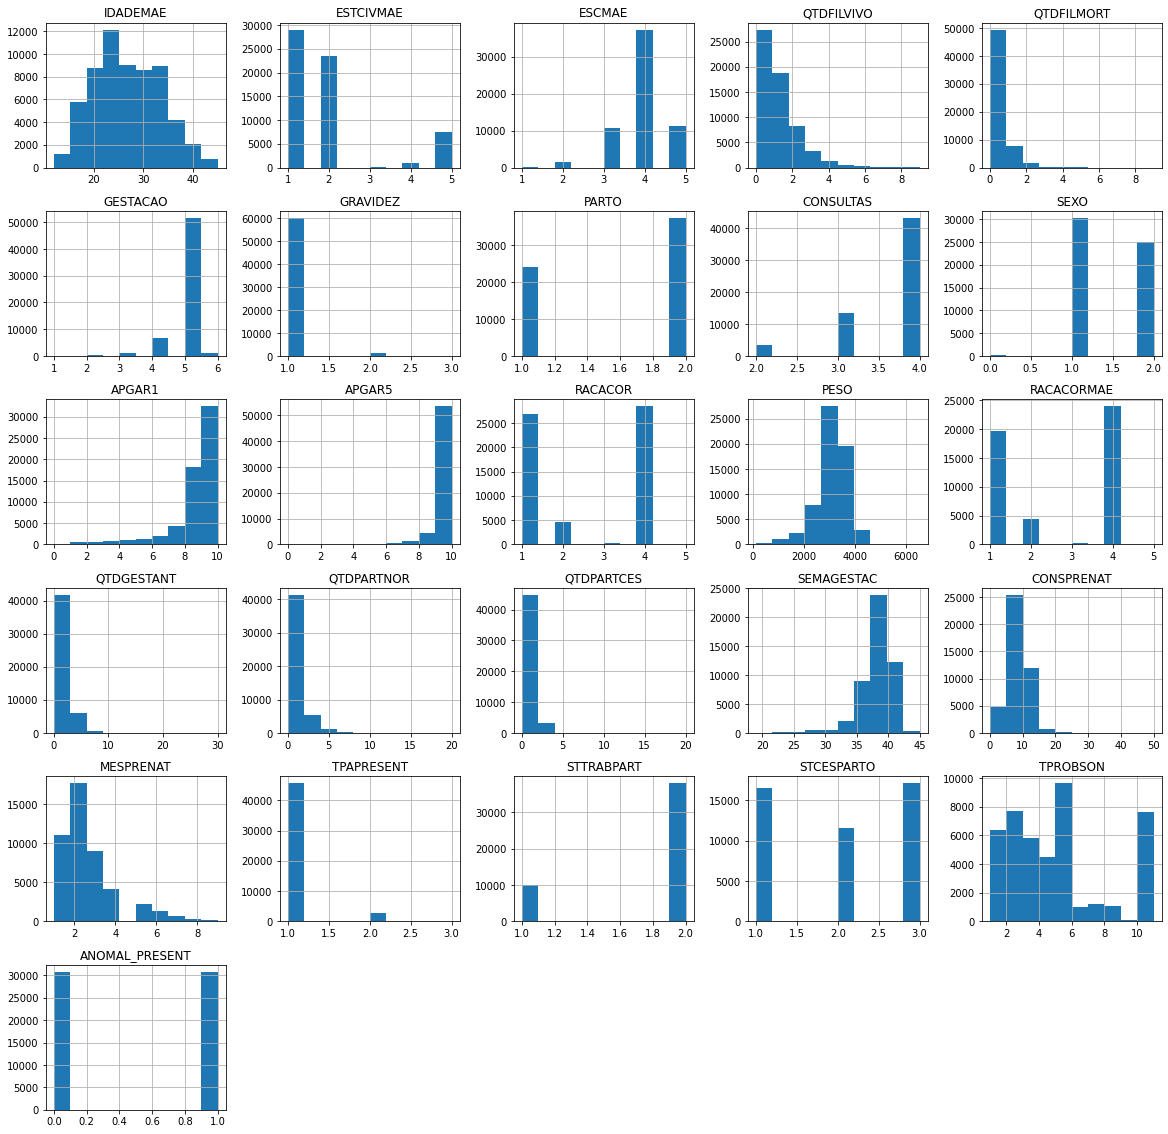

In [7]:
df.hist(figsize = (20,20))

## Engenharia de Features e Seleção Features

Separando Valores Categóricos de Numéricos para processamento diferentes

In [8]:
df = retriever.map_columns_as_categoricals(df)
df_cats = df.select_dtypes(['category'])
df_consts = df[[x for x in df.columns if x not in df_cats.columns]] 

Inputar nos valores NaN

In [9]:
df_cats_imp = fe.max_freq_inputer(df_cats)
df_consts_imp = fe.iterative_inputer_integer(df_consts)
df_cats_imp_codes = fe.get_cat_columns_in_codes(df_cats_imp)
df_hist = df_cats_imp_codes.join(df_consts_imp)

array([[<AxesSubplot:title={'center':'ESTCIVMAE'}>,
        <AxesSubplot:title={'center':'ESCMAE'}>,
        <AxesSubplot:title={'center':'GESTACAO'}>,
        <AxesSubplot:title={'center':'GRAVIDEZ'}>,
        <AxesSubplot:title={'center':'PARTO'}>],
       [<AxesSubplot:title={'center':'CONSULTAS'}>,
        <AxesSubplot:title={'center':'SEXO'}>,
        <AxesSubplot:title={'center':'RACACOR'}>,
        <AxesSubplot:title={'center':'RACACORMAE'}>,
        <AxesSubplot:title={'center':'TPAPRESENT'}>],
       [<AxesSubplot:title={'center':'STTRABPART'}>,
        <AxesSubplot:title={'center':'STCESPARTO'}>,
        <AxesSubplot:title={'center':'TPROBSON'}>,
        <AxesSubplot:title={'center':'IDADEMAE'}>,
        <AxesSubplot:title={'center':'QTDFILVIVO'}>],
       [<AxesSubplot:title={'center':'QTDFILMORT'}>,
        <AxesSubplot:title={'center':'APGAR1'}>,
        <AxesSubplot:title={'center':'APGAR5'}>,
        <AxesSubplot:title={'center':'PESO'}>,
        <AxesSubplot:title={'cen

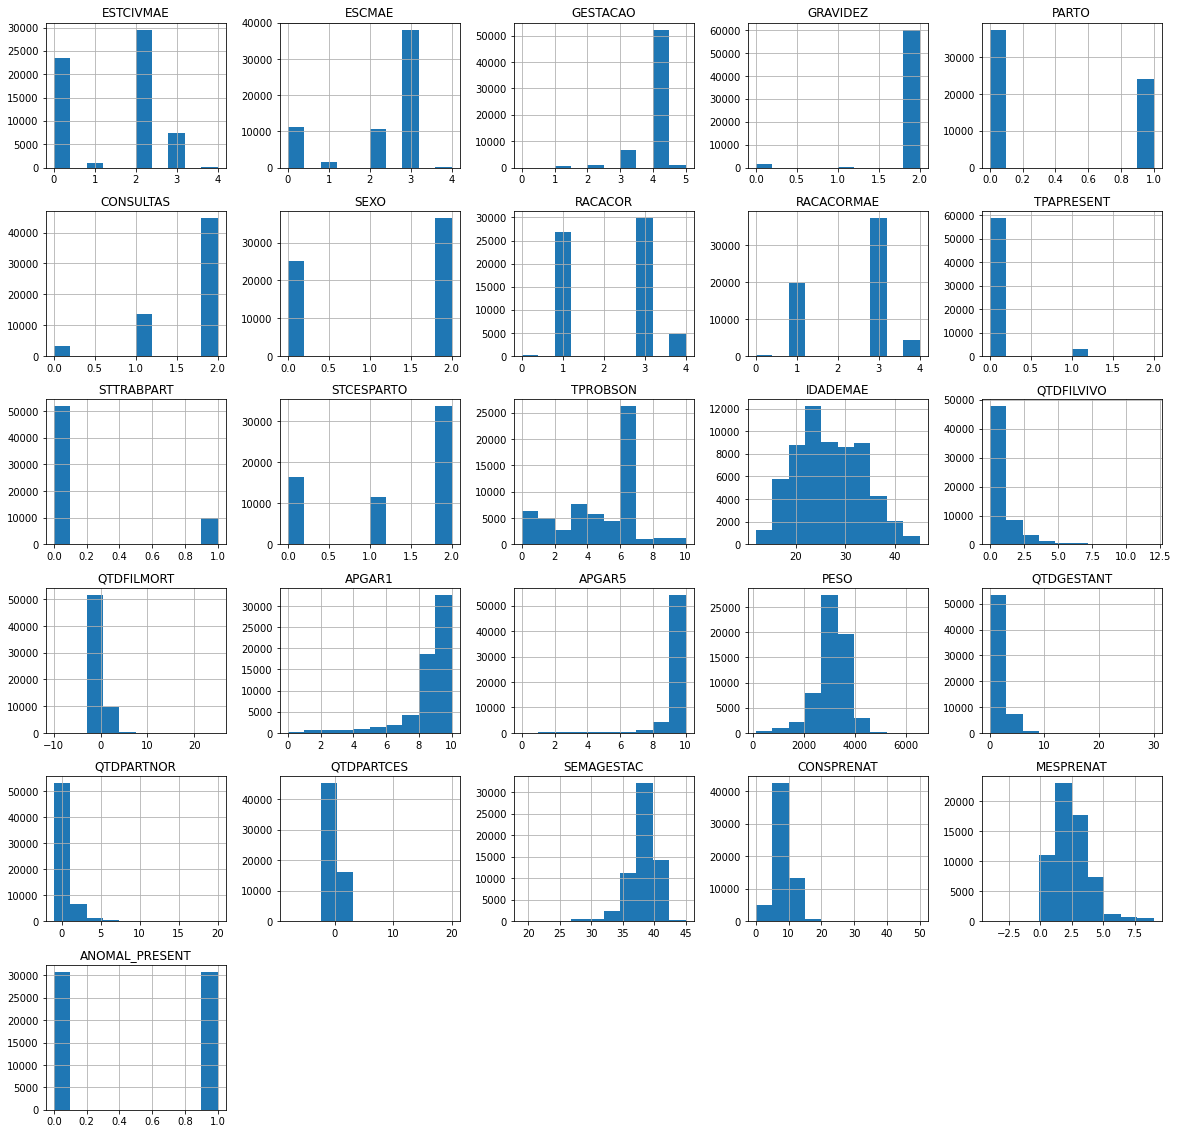

In [10]:
df_hist.hist(figsize = (20,20))

One Hot encoding nas colunas categóricas

In [11]:
df_cats_imp = fe.one_hot_encode_columns(df_cats_imp,df_cats_imp.columns)
df_cats_imp = fe.fill_categorical_no_present_classes(df_cats_imp)
df_cats_imp.head()

Casado  Separado_Judicial  Solteiro  Uniao_Estavel  Viuvo  12_+_esc  \
0       1                  0         0              0      0         0   
1       0                  1         0              0      0         1   
2       1                  0         0              0      0         0   
3       0                  0         1              0      0         0   
4       0                  0         1              0      0         0   

   1_3_esc  4_7_esc  8_11_esc  sem_esc  ...  robson_11  robson_2  robson_3  \
0        0        0         1        0  ...          0         0         0   
1        0        0         0        0  ...          0         0         0   
2        0        0         1        0  ...          0         0         0   
3        0        1         0        0  ...          0         0         1   
4        1        0         0        0  ...          0         0         0   

   robson_4  robson_5  robson_6  robson_7  robson_8  robson_9  \
0         0         1         0         0         0         0   
1         0         1         0         0         0         0   
2         0         1         0         0         0         0   
3         0         0         0         0         0         0   
4         0         0         1         0         0         0   

   sttrabpart_naplica  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  

[5 rows x 57 columns]


Recuperando dataframe processado final

In [12]:
df_processed = df_cats_imp.join(df_consts_imp)
df_processed.head()

Casado  Separado_Judicial  Solteiro  Uniao_Estavel  Viuvo  12_+_esc  \
0       1                  0         0              0      0         0   
1       0                  1         0              0      0         1   
2       1                  0         0              0      0         0   
3       0                  0         1              0      0         0   
4       0                  0         1              0      0         0   

   1_3_esc  4_7_esc  8_11_esc  sem_esc  ...  APGAR1  APGAR5  PESO  QTDGESTANT  \
0        0        0         1        0  ...       8       9  3345           0   
1        0        0         0        0  ...       9       9  3155           2   
2        0        0         1        0  ...       9      10  3285           1   
3        0        1         0        0  ...       8       9  3185           1   
4        1        0         0        0  ...       9      10  3770           0   

   QTDPARTNOR  QTDPARTCES  SEMAGESTAC  CONSPRENAT  MESPRENAT  ANOMAL_PRESENT  
0           0           0          39           8          3               0  
1           0           1          38           9          1               1  
2           0           1          40           8          2               0  
3           1           0          38           4          5               0  
4           0           0          40           8          3               0  

[5 rows x 70 columns]

## Separação em conjunto de treino e teste

In [13]:
X,y = fe._split_df_in_xy(df_processed,target_column='ANOMAL_PRESENT')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## Normalização (Usada apenas em modelos em que ela melhora a eficiência)

In [14]:
scaler = fe.fit_normalizer(df_train=X_train ,normalization_strategy='min_max_scaler')
X_train_norm = fe.normalize_data(X_train,scaler)
X_test_norm = fe.normalize_data(X_test,scaler)

## Auto Sklearn

In [14]:
automl =  autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=5*60, per_run_time_limit=30, n_jobs=multiprocessing.cpu_count())
automl.fit(X_train, y_train)
y_pred_automl = automl.predict(X_test)

In [15]:
print(classification_report(y_test, y_pred_automl))

              precision    recall  f1-score   support

           0       0.61      0.57      0.59      6200
           1       0.59      0.63      0.61      6134

    accuracy                           0.60     12334
   macro avg       0.60      0.60      0.60     12334
weighted avg       0.60      0.60      0.60     12334



In [16]:
profiler_data = PipelineProfiler.import_autosklearn(automl)
PipelineProfiler.plot_pipeline_matrix(profiler_data)

## Random Forest Model
Não usa normalização

Validação Cruzada

In [17]:
from sklearn.ensemble import RandomForestClassifier
clf_val = make_pipeline(RandomForestClassifier(max_depth=20, random_state=0,max_features='log2'))
scores = cross_val_score(clf_val, X_train, y_train, cv=10)
print(scores)

[0.60802594 0.6157276  0.6192986  0.60409487 0.61443341 0.61869045
 0.59720251 0.60896006 0.60308129 0.61646057]


### Treinando o Modelo


In [18]:
clf = RandomForestClassifier(max_depth=20, random_state=42,max_features='log2')#clf.fit(X_train_norm, y_train_resampled.replace({0:1,1:0}))
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features='log2', random_state=42)

### Predizendo Conjunto de Teste

In [19]:
y_pred = clf.predict(X_test)

### Explicando os resultados do modelo através do ranqueamento das features mais importantes para a discriminação dos dados entre as classes

https://machinelearningmastery.com/calculate-feature-importance-with-python/

In [20]:
fig = plt.Figure()
importance = clf.feature_importances_

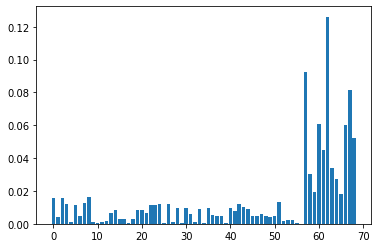

In [21]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [22]:
df_explain = pd.DataFrame(columns=['feature','importance'])
df_explain['feature'] = X_train.columns
df_explain['importance'] = importance
df_explain_ordered = df_explain.sort_values('importance',ascending=False)
df_explain_ordered.head(10)

feature  importance
62        PESO    0.126086
57    IDADEMAE    0.092153
67  CONSPRENAT    0.081504
60      APGAR1    0.060470
66  SEMAGESTAC    0.060404
68   MESPRENAT    0.052324
61      APGAR5    0.044718
63  QTDGESTANT    0.034262
58  QTDFILVIVO    0.030381
64  QTDPARTNOR    0.026999

## XGBOOST

In [23]:
# fit model no training data
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

/l/disk0/msasso/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[16:25:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
/l/disk0/msasso/.local/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [24]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.63      0.65      0.64      6200
           1       0.64      0.62      0.63      6134

    accuracy                           0.63     12334
   macro avg       0.63      0.63      0.63     12334
weighted avg       0.63      0.63      0.63     12334



In [25]:
feature_importances_xgb = xgb_model.get_booster().get_score(importance_type="gain")
#pd.DataFrame(feature_importances_xgb)
feature = [f for f, i in feature_importances_xgb.items()]
importance = [i for f, i in feature_importances_xgb.items()]
feature_importances_xgboost = pd.DataFrame({"feature":feature,"importance":importance})
feature_importances_xgboost = feature_importances_xgboost.sort_values('importance',ascending=False)
feature_importances_xgboost.head(10)

feature  importance
0                   APGAR1   13.357238
8     stcesparto_ces_antes   12.207524
9           sttrabpart_nao   11.413953
14  tpa_pelvica_oupudalica   10.203540
4                 robson_5    8.870059
6               CONSPRENAT    8.754002
20           parto_cesareo    8.643661
15         raca_mae_branca    8.565550
24               robson_11    7.702176
19                sexo_fem    7.685706

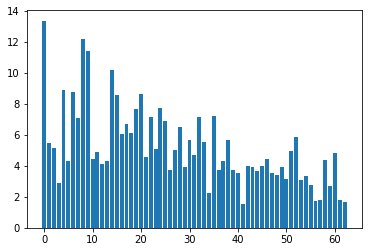

In [26]:
plt.bar(feature_importances_xgboost.index, feature_importances_xgboost['importance'])
plt.show()

## Extraindo Métricas - Melhor Modelo

In [27]:
if accuracy_score(y_pred,y_test) > accuracy_score(y_pred_xgb,y_test):
    best_model = clf
    y_pred_best = y_pred
else:
    best_model = xgb_model
    y_pred_best = y_pred_xgb

Relatório de Classificação

In [28]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.63      0.65      0.64      6200
           1       0.64      0.62      0.63      6134

    accuracy                           0.63     12334
   macro avg       0.63      0.63      0.63     12334
weighted avg       0.63      0.63      0.63     12334



Curva ROC

<AxesSubplot:title={'center':'Curva ROC'}, xlabel='Taxa de Falso Positivo', ylabel='Taxa de Verdadeiro Positivo'>

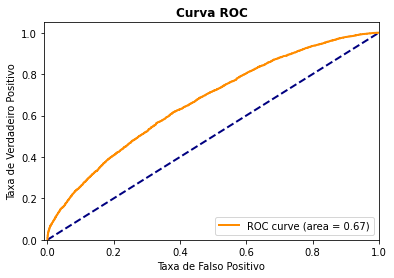

In [29]:
y_pred_prob = clf.predict_proba(X_test)
vi.plot_roc_curve(y_true = np.array(y_test), y_prob = y_pred_prob, labels = ['not_anomalie','anomalie'])

Matriz de Confusão

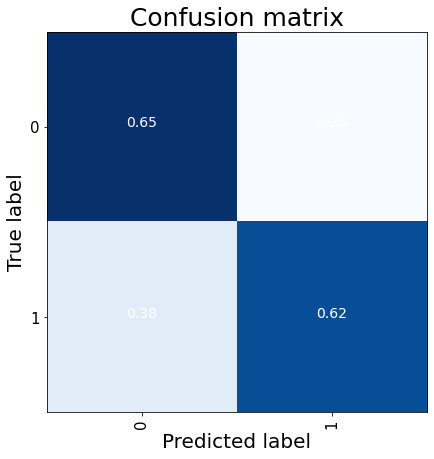

In [30]:
vi.plot_confusion_matrix(y_true=y_test, y_pred=y_pred_best,labels=y_train.unique())

## Salvando modelo

In [32]:
filepath = os.path.join(small_data_dir,'model_membros.sav')
io_utils.save_pickle(filepath=filepath,info=best_model)

## Fim